# Training an LSTM model on books dataset

First we import necessary packages for our project

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

## Preparing Dataset

Initialize the project root, data, and model directories.

In [2]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'data/'
model_dir = project_root / 'models/bn_lstm'
os.makedirs(model_dir, exist_ok=True) # Create if does not exist

Get list of files in the data directory

In [3]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Split the files for training and testing. We are randomly shuffling the files and selecting only first 40 for training and next 10 for testing.

In [4]:
random.shuffle(filenames) # randomly shuffle the data
training_filenames = filenames[:40]
test_filenames = filenames[:10]

Now we create a function that creates a tokenizer with `max_words`, fit it on training files and save to `model_dir`.

In [5]:
def create_tokenizer(files, max_words, model_dir):
    tokenizer = Tokenizer(num_words=max_words)
    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().split('\n')
            tokenizer.fit_on_texts(lines)
    save_path = model_dir / 'tokenizer.pickle'
    # save the tokenizer in model dir
    with open(save_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return tokenizer

Define max words and max sequence length

In [6]:
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

Now create the tokenizer calling the function and passing the defined constants

In [7]:
tokenizer = create_tokenizer(training_filenames, MAX_WORDS, model_dir)

100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.21it/s]


`create_dataset` creates a dataset from given `files` and returns two variables - `predictors` which is a sequence of previous words of length `max_sequence_length - 1` and `labels` which is an integer between 0 to `max_words + 1`.
Note that, converting to categorical variables leads to `MemoryError` since it tries to create a sequence of `number of elements in training or test set * (MAX_WORDS + 1)` shape. We are following [this blog](https://medium.com/deep-learning-with-keras/which-activation-loss-functions-in-multi-class-clasification-4cd599e4e61f) and keeping the label as an integer.

In [35]:
def create_dataset(tokenizer, files, max_words, max_sequence_length):
    input_sequences = []

    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().split('\n')
            token_list = tokenizer.texts_to_sequences(lines)
            for tokens in token_list:
                for i in range(1, len(tokens)):
                    # keep only sequences of length <= max_sequence_length
                    n_gram_sequence = tokens[max(0, i+1-max_sequence_length):i+1]
                    input_sequences.append(n_gram_sequence)

    # pad sequences with 0s so that all sequences have same length
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequences, maxlen=max_sequence_length, padding='pre')

    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    del input_sequences
    return predictors, label

Now we create training dataset `X_train` and `y_train` from training files and test dataset `X_test` and `y_test` from test files.

In [36]:
X_train, y_train = create_dataset(tokenizer, training_filenames, MAX_WORDS, MAX_SEQUENCE_LENGTH)
X_test, y_test = create_dataset(tokenizer, test_filenames, MAX_WORDS, MAX_SEQUENCE_LENGTH)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.85it/s]


## Creating and Training Model

Create a sequential LSTM model and compile the model with loss `sparse_categorical_crossentropy`, optimizer `adam` and metric `sparse_categorical_accuracy`. We are using sparse categorical crossentropy since the values are integers, not one-hot encoded, see this question on [stackexchange](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other) for details.

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(150),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['sparse_categorical_accuracy'])

Create callbacks `EarlyStopping` which monitors `val_loss` for 10 epochs, and `ModelCheckpoint` which saves best model to `model_dir`.

In [71]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, mode='auto')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    str(model_dir), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Start training the model and store the training results in `history`.

In [72]:
history = model.fit(X_train, y_train, batch_size=1024,
                    epochs=50, validation_split=0.2,
                    callbacks=[earlystop, checkpoint])

Epoch 1/50
743/744 [============================>.] - ETA: 0s - loss: 7.7105 - sparse_categorical_accuracy: 0.0170
Epoch 1: val_loss improved from inf to 7.62724, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


744/744 [==============================] - 59s 78ms/step - loss: 7.7103 - sparse_categorical_accuracy: 0.0170 - val_loss: 7.6272 - val_sparse_categorical_accuracy: 0.0260
Epoch 2/50
743/744 [============================>.] - ETA: 0s - loss: 7.2342 - sparse_categorical_accuracy: 0.0342
Epoch 2: val_loss improved from 7.62724 to 7.27187, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


744/744 [==============================] - 58s 77ms/step - loss: 7.2340 - sparse_categorical_accuracy: 0.0342 - val_loss: 7.2719 - val_sparse_categorical_accuracy: 0.0432
Epoch 3/50
743/744 [============================>.] - ETA: 0s - loss: 6.8651 - sparse_categorical_accuracy: 0.0486
Epoch 3: val_loss improved from 7.27187 to 7.17701, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


744/744 [==============================] - 57s 77ms/step - loss: 6.8651 - sparse_categorical_accuracy: 0.0486 - val_loss: 7.1770 - val_sparse_categorical_accuracy: 0.0452
Epoch 4/50
743/744 [============================>.] - ETA: 0s - loss: 6.5927 - sparse_categorical_accuracy: 0.0605
Epoch 4: val_loss improved from 7.17701 to 7.07484, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


744/744 [==============================] - 58s 78ms/step - loss: 6.5926 - sparse_categorical_accuracy: 0.0605 - val_loss: 7.0748 - val_sparse_categorical_accuracy: 0.0519
Epoch 5/50
743/744 [============================>.] - ETA: 0s - loss: 6.4057 - sparse_categorical_accuracy: 0.0697
Epoch 5: val_loss improved from 7.07484 to 7.02666, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


744/744 [==============================] - 57s 77ms/step - loss: 6.4057 - sparse_categorical_accuracy: 0.0697 - val_loss: 7.0267 - val_sparse_categorical_accuracy: 0.0582
Epoch 6/50
743/744 [============================>.] - ETA: 0s - loss: 6.2611 - sparse_categorical_accuracy: 0.0772
Epoch 6: val_loss did not improve from 7.02666
744/744 [==============================] - 55s 74ms/step - loss: 6.2612 - sparse_categorical_accuracy: 0.0772 - val_loss: 7.0287 - val_sparse_categorical_accuracy: 0.0609
Epoch 7/50
743/744 [============================>.] - ETA: 0s - loss: 6.1404 - sparse_categorical_accuracy: 0.0837
Epoch 7: val_loss improved from 7.02666 to 7.01788, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


744/744 [==============================] - 57s 77ms/step - loss: 6.1404 - sparse_categorical_accuracy: 0.0837 - val_loss: 7.0179 - val_sparse_categorical_accuracy: 0.0646
Epoch 8/50
743/744 [============================>.] - ETA: 0s - loss: 6.0362 - sparse_categorical_accuracy: 0.0893
Epoch 8: val_loss did not improve from 7.01788
744/744 [==============================] - 55s 74ms/step - loss: 6.0362 - sparse_categorical_accuracy: 0.0893 - val_loss: 7.0597 - val_sparse_categorical_accuracy: 0.0639
Epoch 9/50
743/744 [============================>.] - ETA: 0s - loss: 5.9436 - sparse_categorical_accuracy: 0.0940
Epoch 9: val_loss did not improve from 7.01788
744/744 [==============================] - 55s 74ms/step - loss: 5.9435 - sparse_categorical_accuracy: 0.0940 - val_loss: 7.0981 - val_sparse_categorical_accuracy: 0.0644
Epoch 10/50
743/744 [============================>.] - ETA: 0s - loss: 5.8575 - sparse_categorical_accuracy: 0.0989
Epoch 10: val_loss did not improve from 7.01788

Save the `history` for later use.

In [73]:
with open(str(model_dir / 'model_lstm_150_history'), 'wb') as history_pkl:
    pickle.dump(history, history_pkl)

INFO:tensorflow:Assets written to: ram://beb2fd7c-2cae-47f1-8c53-b3d45e5622c2/assets


INFO:tensorflow:Assets written to: ram://beb2fd7c-2cae-47f1-8c53-b3d45e5622c2/assets


And save the `model` as well

In [75]:
model.save(str(model_dir))

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


Next, we plot the training accuracy and loss from `history.history`.

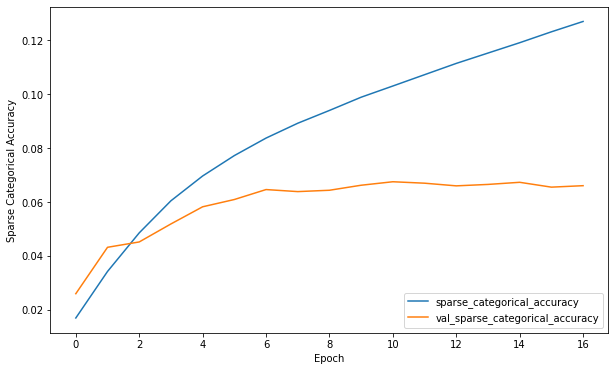

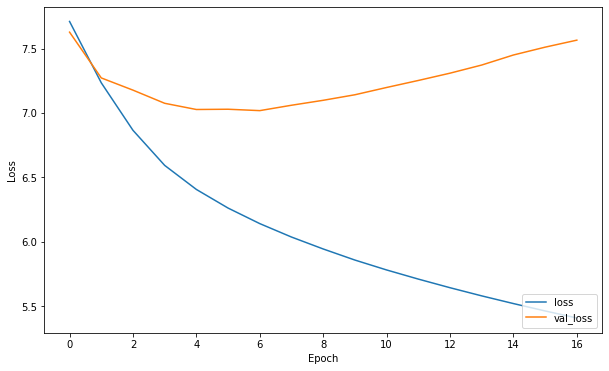

In [76]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig(str(model_dir / f'sparse_categorical_accuracy.png'), dpi=fig.dpi)

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
fig.savefig(str(model_dir / f'sparse_categorical_loss.png'), dpi=fig.dpi)

Finally we evaluate the model on test data.

In [78]:
model.evaluate(X_test, y_test, batch_size=1024)

283/283 [==============================] - 9s 32ms/step - loss: 5.1811 - sparse_categorical_accuracy: 0.1430


[5.181066513061523, 0.1429920494556427]